In [126]:
from numba import cuda
import numpy as np
import time

from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

**LAB 2**

In [127]:
cuda.detect()

gpu = cuda.get_current_device()
num_processor = gpu.MULTIPROCESSOR_COUNT

print(f"Number of processors: {num_processor}")

free, total = cuda.current_context().get_memory_info()

print(f"Free: {free / (1024**3):.2f} GB")
print(f"Total {total/ (1024**3):.2f} GB")



Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-ddbc9a5f-3ddb-ab6d-20df-fa2140f7dfb0
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported
Number of processors: 40
Free: 14.59 GB
Total 14.74 GB


**LAB 3**

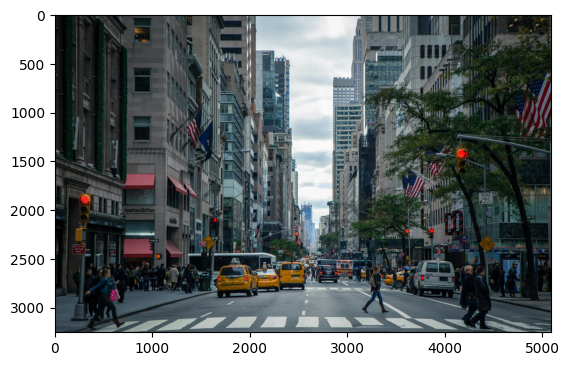

(3253, 5088, 3)
Number of pixels: 16551264
(16551264, 3)


In [128]:
import matplotlib.pyplot as plt

# image_path = "image.jpg"
image_path = "img2.jpg"

image = plt.imread(image_path)
plt.imshow(image)
plt.show()

print(image.shape)

H, W, C = image.shape

pixel_count = H * W

print(f"Number of pixels: {pixel_count}")

flattened_image = image.reshape(pixel_count, 3)

print(flattened_image.shape)


In [129]:
def gray_scale_cpu(flat_src):
    n = flat_src.shape[0]
    flat_dst = np.empty_like(flat_src)

    start = time.time()
    for i in range(n):
        g = np.uint8((flat_src[i, 0] + flat_src[i, 1] + flat_src[i, 2]) / 3)
        flat_dst[i, 0] = g
        flat_dst[i, 1] = g
        flat_dst[i, 2] = g
    end = time.time()


    return flat_dst, (end - start)

/tmp/ipython-input-2903683628.py:7: RuntimeWarning: overflow encountered in scalar add
  g = np.uint8((flat_src[i, 0] + flat_src[i, 1] + flat_src[i, 2]) / 3)


CPU grayscale done in 37.2638s


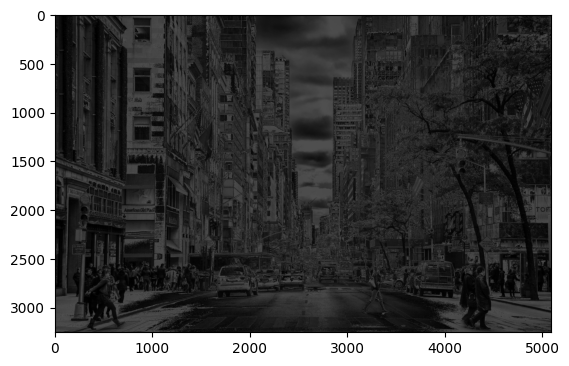

In [130]:
gray_cpu_flatten, cpu_time = gray_scale_cpu(flattened_image)
print(f"CPU grayscale done in {cpu_time:.4f}s")
gray_cpu_image = gray_cpu_flatten.reshape(H, W, C)
plt.imshow(gray_cpu_image)
plt.show()

In [131]:
from numba import cuda
import numpy as np
import time

@cuda.jit
def grayscale_kernel(src, dst):
    i = cuda.grid(1)
    if i < src.shape[0]:
        g = np.uint8((src[i,0] + src[i,1] + src[i,2]) / 3)
        dst[i,0] = g
        dst[i,1] = g
        dst[i,2] = g

def grayscale_gpu(flat_img, nthreads=256):
    n = flat_img.shape[0]
    blocks = (n + nthreads - 1) // nthreads

    d_src = cuda.to_device(flat_img)
    d_dst = cuda.device_array_like(flat_img)

    start = time.time()
    grayscale_kernel[blocks, nthreads](d_src, d_dst)
    cuda.synchronize()
    end = time.time()

    print(f"GPU grayscale done in {end - start:.4f}s")
    return d_dst.copy_to_host(), end - start

thread = 64
GPU grayscale done in 0.0771s
thread = 128
GPU grayscale done in 0.0042s
thread = 256
GPU grayscale done in 0.0042s
thread = 1024
GPU grayscale done in 0.0045s


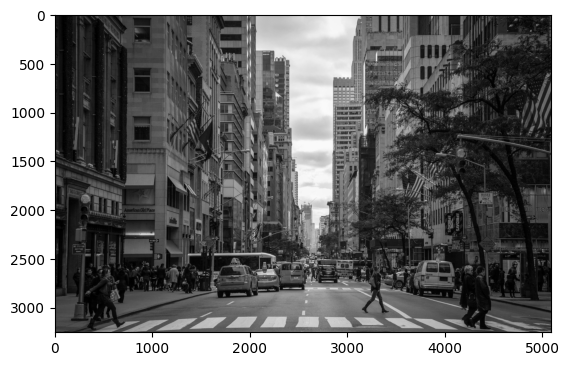

In [132]:
threads = [64, 128, 256, 1024]
time_gpu = []
result = None

for nthread in threads:
  print(f"thread = {nthread}")
  image, gpu_time = grayscale_gpu(flattened_image, nthreads=nthread)
  time_gpu.append(gpu_time)
  if result is None:
    gray_gpu_image = image.reshape(H, W, 3)
    result = gray_gpu_image


plt.imshow(result)
plt.show()

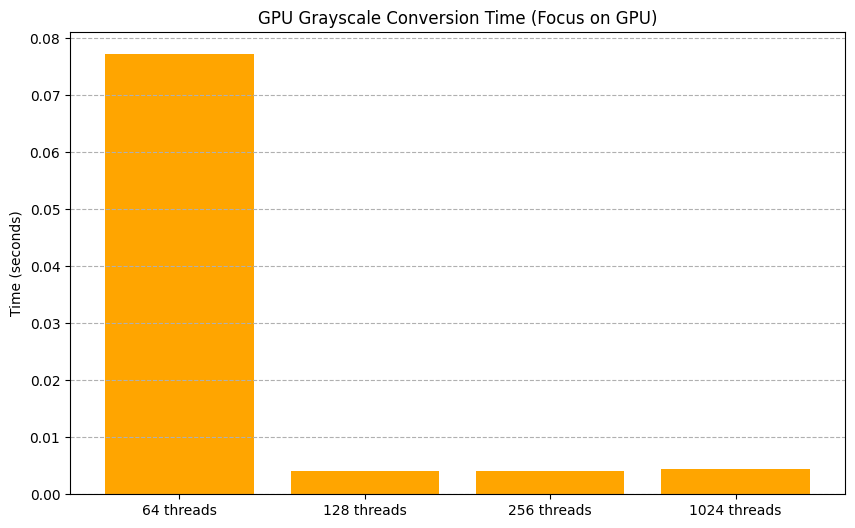

In [133]:
plt.figure(figsize=(10, 6))
plt.bar([f'{t} threads' for t in threads], time_gpu, color='orange')
plt.ylabel('Time (seconds)')
plt.title('GPU Grayscale Conversion Time (Focus on GPU)')
plt.grid(axis='y', linestyle='--')
plt.show()

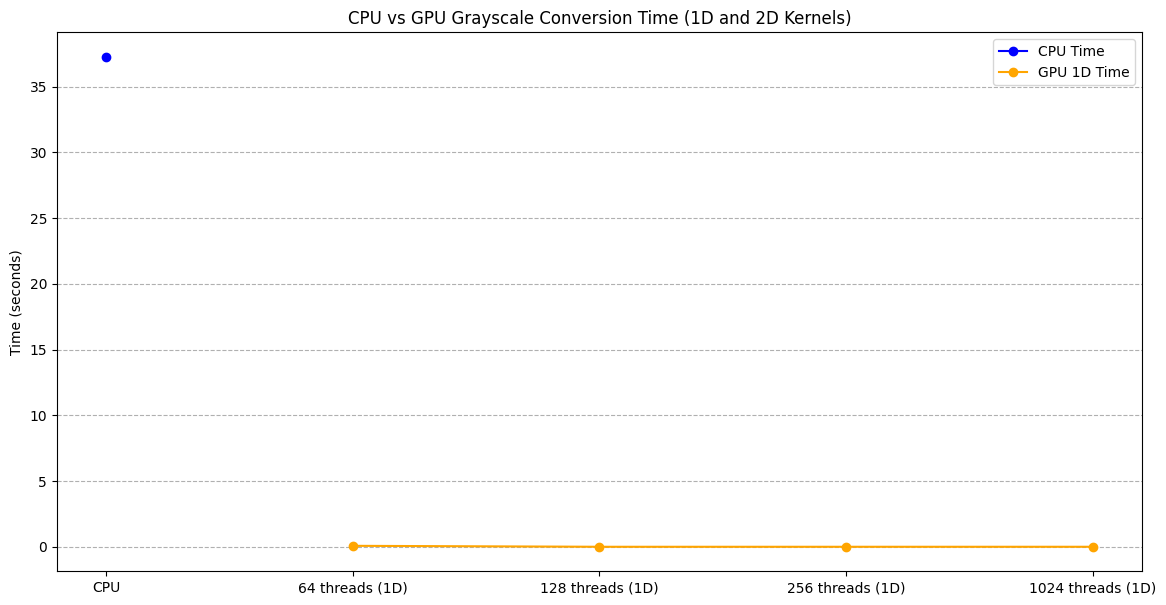

In [134]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['CPU'] + [f'{t} threads (1D)' for t in threads] + [f'{t}x{t} blocks (2D)' for t in [16, 32, 64]]
times = [cpu_time] + time_gpu

plt.figure(figsize=(14, 7))
plt.plot(['CPU'], [cpu_time], marker='o', label='CPU Time', color='blue')
plt.plot([f'{t} threads (1D)' for t in threads], time_gpu, marker='o', label='GPU 1D Time', color='orange')

plt.ylabel('Time (seconds)')
plt.title('CPU vs GPU Grayscale Conversion Time (1D and 2D Kernels)')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

**Lab 4**

In [135]:
@cuda.jit
def grayscale_kernel_2d(src, dst):
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if y < src.shape[0] and x < src.shape[1]:
        r = float(src[y, x, 0])
        g = float(src[y, x, 1])
        b = float(src[y, x, 2])

        gray_val = np.uint8((r + g + b) / 3.0)

        dst[y, x, 0] = dst[y, x, 1] = dst[y, x, 2] = gray_val


def grayscale_gpu_2d(src, block_dim):
    print(f"shape = {src.shape}")
    H, W, _ = src.shape
    grid_w = (W + block_dim[0] - 1) // block_dim[0]
    grid_h = (H + block_dim[1] - 1) // block_dim[1]

    grid_dim = (grid_w, grid_h)

    d_src = cuda.to_device(src)
    d_dst = cuda.device_array_like(src)

    start = time.time()
    grayscale_kernel_2d[grid_dim, block_dim](d_src, d_dst)
    cuda.synchronize()
    end = time.time()

    elapsed_time = end - start
    print(f"GPU 2d with {block_dim} run in {elapsed_time:.4f}s")

    return d_dst.copy_to_host(), elapsed_time

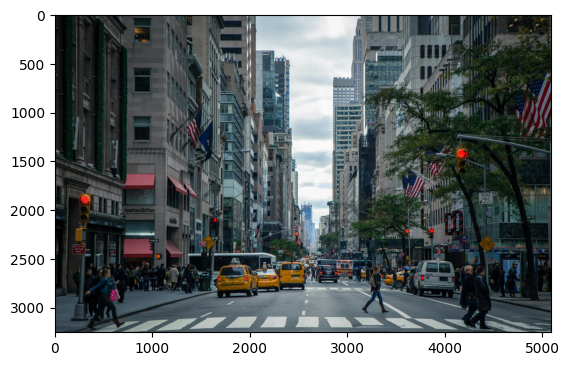

shape = (3253, 5088, 3)
GPU 2d with (16, 16) run in 0.1431s
shape = (3253, 5088, 3)
GPU 2d with (32, 32) run in 0.0063s


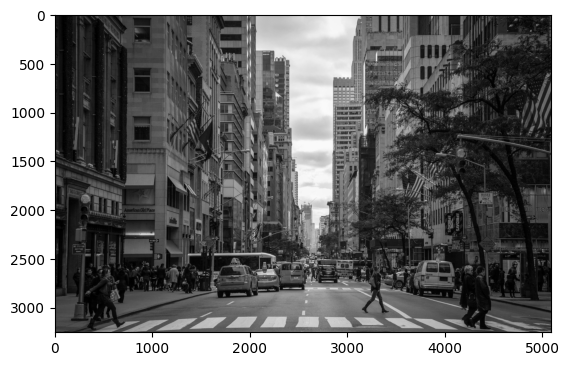

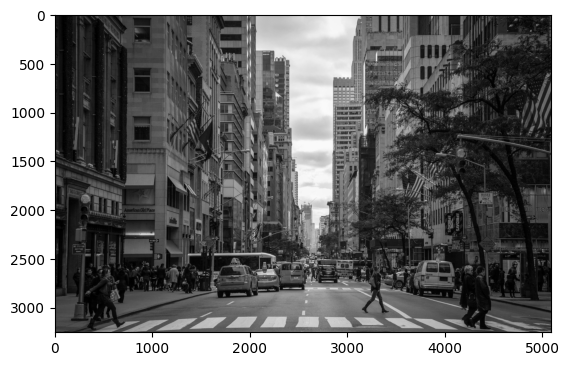

In [136]:
result_2d = []
time_2d = []

image_2d = plt.imread(image_path)
plt.imshow(image_2d)
plt.show()


for i in [(16, 16), (32,32)]:
  image_2d_result, gpu_2d_time = grayscale_gpu_2d(image_2d, block_dim=i)
  time_2d.append(gpu_2d_time)
  result_2d.append(image_2d_result)

for image in result_2d:
  plt.imshow(image)
  plt.show()

In [137]:
gaussian_kernel_raw = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)

gaussian_kernel = gaussian_kernel_raw / gaussian_kernel_raw.sum()

print("7x7 Gaussian Kernel:")
print(gaussian_kernel)
print(f"\nKernel sum: {gaussian_kernel.sum()}")

7x7 Gaussian Kernel:
[[0.         0.         0.00099701 0.00199402 0.00099701 0.
  0.        ]
 [0.         0.00299103 0.01296112 0.0219342  0.01296112 0.00299103
  0.        ]
 [0.00099701 0.01296112 0.05882353 0.09670987 0.05882353 0.01296112
  0.00099701]
 [0.00199402 0.0219342  0.09670987 0.15852442 0.09670987 0.0219342
  0.00199402]
 [0.00099701 0.01296112 0.05882353 0.09670987 0.05882353 0.01296112
  0.00099701]
 [0.         0.00299103 0.01296112 0.0219342  0.01296112 0.00299103
  0.        ]
 [0.         0.         0.00099701 0.00199402 0.00099701 0.
  0.        ]]

Kernel sum: 1.0


In [138]:
from numba import cuda

@cuda.jit
def gaussian_blur_kernel_3d_no_shared(src_3d, dst_3d, kernel):
    x, y = cuda.grid(2)

    height, width, channels = src_3d.shape

    if y >= height or x >= width:
        return

    radius_y = kernel.shape[0] // 2
    radius_x = kernel.shape[1] // 2

    for c in range(channels):
        pixel_sum = 0.0
        for ky in range(-radius_y, radius_y + 1):
            for kx in range(-radius_x, radius_x + 1):
                iy = y + ky
                ix = x + kx

                if 0 <= iy < height and 0 <= ix < width:
                    pixel_value = src_3d[iy, ix, c]
                    kernel_value = kernel[ky + radius_y, kx + radius_x]
                    pixel_sum += pixel_value * kernel_value

        dst_3d[y, x, c] = pixel_sum

@cuda.jit
def gaussian_blur_kernel_3d_shared(src_3d, dst_3d, kernel):
    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    height, width, channels = src_3d.shape
    kernel_size = kernel.shape[0]
    radius = kernel_size // 2

    shared_kernel = cuda.shared.array((7, 7), dtype=np.float32)

    if tx < kernel_size and ty < kernel_size:
        shared_kernel[ty, tx] = kernel[ty, tx]

    cuda.syncthreads()

    if y >= height or x >= width:
        return

    for c in range(channels):
        pixel_sum = 0.0

        for ky in range(-radius, radius + 1):
            for kx in range(-radius, radius + 1):
                iy = y + ky
                ix = x + kx

                if 0 <= iy < height and 0 <= ix < width:
                    pixel_value = src_3d[iy, ix, c]
                    kernel_value = shared_kernel[ky + radius, kx + radius]
                    pixel_sum += pixel_value * kernel_value

        dst_3d[y, x, c] = pixel_sum

In [139]:
import math
from numba import cuda

def apply_gaussian_blur_3d_no_shared(image_array_3d, kernel_array):

    d_input_image = cuda.to_device(image_array_3d)
    d_kernel = cuda.to_device(kernel_array)
    d_output_image = cuda.device_array_like(image_array_3d)

    threads_per_block = (16, 16)
    height, width, channels = image_array_3d.shape

    blocks_per_grid_x = math.ceil(width / threads_per_block[0])
    blocks_per_grid_y = math.ceil(height / threads_per_block[1])

    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    gaussian_blur_kernel_3d_no_shared[blocks_per_grid, threads_per_block](
        d_input_image, d_output_image, d_kernel
    )
    cuda.synchronize()

    output_array = d_output_image.copy_to_host()

    return output_array

In [140]:
def apply_gaussian_blur_3d_shared(image_array_3d, kernel_array):
    d_input_image = cuda.to_device(image_array_3d)
    d_kernel = cuda.to_device(kernel_array)
    d_output_image = cuda.device_array_like(image_array_3d)

    threads_per_block = (16, 16)
    height, width, channels = image_array_3d.shape

    blocks_per_grid_x = math.ceil(width / threads_per_block[0])
    blocks_per_grid_y = math.ceil(height / threads_per_block[1])

    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    gaussian_blur_kernel_3d_shared[blocks_per_grid, threads_per_block](
        d_input_image, d_output_image, d_kernel
    )
    cuda.synchronize()

    output_array = d_output_image.copy_to_host()

    return output_array

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import time

image_3d = result_2d[0]

if image_3d.dtype == np.uint8:
    image_3d = image_3d.astype(np.float32) / 255.0

gaussian_kernel_raw = np.array([
    [0,0,1,2,1,0,0],
     [0,3,13,22,13,3,0],
      [1,13,59,97,59,13,1],
       [2,22,97,159,97,22,2],
        [1,13,59,97,59,13,1],
         [0,3,13,22,13,3,0],
          [0,0,1,2,1,0,0]
], dtype=np.float32)

gaussian_kernel_normalized = gaussian_kernel_raw / gaussian_kernel_raw.sum()

start_time = time.time()
blurred_no_shared = apply_gaussian_blur_3d_no_shared(image_3d, gaussian_kernel_normalized)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time elapsed: {elapsed_time:.4f} seconds")

start_time_shared = time.time()
blurred_with_shared = apply_gaussian_blur_3d_shared(image_3d, gaussian_kernel_normalized)
end_time_shared = time.time()

time_with_shared = end_time_shared - start_time_shared
print(f"Time elapsed: {time_with_shared:.6f} seconds")

speedup = elapsed_time / time_with_shared

print(f"No Shared Memory:   {elapsed_time:.6f} seconds")
print(f"With Shared Memory: {time_with_shared:.6f} seconds")
print(f"SPEEDUP:            {speedup:.2f}x faster!")

Time elapsed: 0.4344 seconds
TESTING WITH SHARED MEMORY
Time elapsed: 0.414431 seconds

RESULTS SUMMARY
No Shared Memory:   0.434424 seconds
With Shared Memory: 0.414431 seconds
SPEEDUP:            1.05x faster!


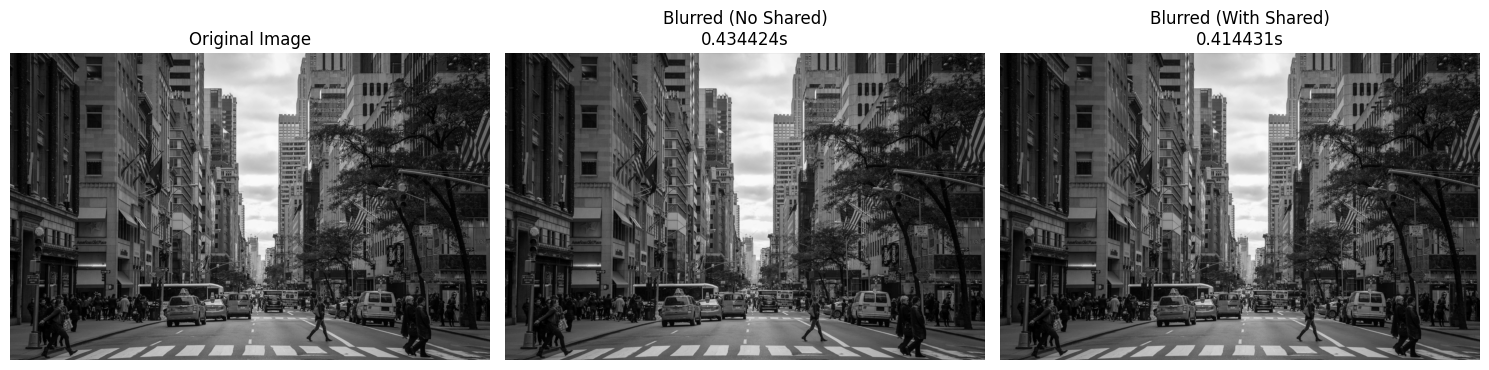

In [142]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_3d)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
blurred_no_shared_display = np.clip(blurred_no_shared, 0, 1)
plt.imshow(blurred_no_shared_display)
plt.title(f'Blurred (No Shared)\n{elapsed_time:.6f}s')
plt.axis('off')

plt.subplot(1, 3, 3)
blurred_with_shared_display = np.clip(blurred_with_shared, 0, 1)
plt.imshow(blurred_with_shared_display)
plt.title(f'Blurred (With Shared)\n{time_with_shared:.6f}s')
plt.axis('off')

plt.tight_layout()
plt.show()